In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import yaml
import geopandas as gpd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import sys
sys.path.insert(1, '../') 
from utils.load_data import *
from utils import generate_regional_breakdown
from models import size_the_network

with open("../config.yaml") as f:
    config = yaml.safe_load(f)

In [2]:
# Load the data
stations = load_stations()
# rrn_vsmap = load_rrn_vsmap()
# rrn_bornage = load_rrn_bornage()
regions = load_regions()
traffic = load_traffic()
depreg = load_depreg()
# airesPL = load_airesPL()

# Traffic by departement

In [3]:
print(traffic.columns)
print(traffic.shape)
traffic.head(2)

Index(['dateRefere', 'route', 'longueur', 'prD', 'depPrD', 'concession',
       'absD', 'cumulD', 'xD', 'yD', 'zD', 'prF', 'depPrF', 'concessi_1',
       'absF', 'cumulF', 'xF', 'yF', 'zF', 'cote', 'anneeMesur', 'typeCompta',
       'tmja', 'pctPL', 'geometry'],
      dtype='object')
(5968, 25)


,dateRefere,route,longueur,prD,depPrD,concession,absD,cumulD,xD,yD,zD,prF,depPrF,concessi_1,absF,cumulF,xF,yF,zF,cote,anneeMesur,typeCompta,tmja,pctPL,geometry
0,2018-01-01,69D0301,6055.0,2,69,N,-981.0,0.0,844036.84,6510806.45,0.0,7,69,N,71.0,6055.0,849346.89,6509342.34,0.0,I,0,None,0,0.0,"LINESTRING (844036.841 6510806.450, 844044.447..."
1,2018-01-01,69D0383,13752.0,4,69,N,-494.0,0.0,846831.30,6522372.16,0.0,17,69,N,544.0,13752.0,843537.87,6512429.80,0.0,I,0,None,0,0.0,"LINESTRING (846831.303 6522372.160, 846865.124..."


In [4]:
region_breakdown = generate_regional_breakdown.create_region_breakdown(traffic, depreg)
region_breakdown

{'Auvergne-Rhône-Alpes': 0.22661,
 'Bourgogne-Franche-Comté': 0.09619,
 'Bretagne': 0.04036,
 'Centre-Val de Loire': 0.04309,
 'Grand Est': 0.09282,
 'Hauts-de-France': 0.05246,
 'Normandie': 0.05039,
 'Nouvelle-Aquitaine': 0.11209,
 'Occitanie': 0.08506,
 'Pays de la Loire': 0.03724,
 "Provence-Alpes-Côte d'Azur": 0.04399,
 'Île-de-France': 0.1197}

# Model

In [5]:
manufacturers_desc = {
      'man_1': {'name': 'Daimler Truck & Volvo', 'prototype': 'GenH2 Truck', 'technology': 'Hydrogen fuel cell','tank_size': 80, 'autonomy': 1000, 'type_of_PL': 'long-distance'}
    , 'man_2': {'name': 'DAF', 'prototype': 'XF, XG and XG+', 'technology': 'Internal combustion','tank_size': 15, 'autonomy': 150, 'type_of_PL': 'short-distance'}
    , 'man_3': {'name': 'Iveco & Nikola & Hyundai', 'prototype': 'Nikola TRE', 'technology': 'Hydrogen fuel cell','tank_size': 32, 'autonomy': 400, 'type_of_PL': 'long-distance'}
}

stations_desc = {
      'small': {'capex': 3*10**6, 'depreciation': 15, 'yearly_opex': 0.10, 'storage_onsite': 2000, 'construction_time': 1, 'footprint': 650, 'profitability_threshold': 0.9, 'nb_terminals': 2},
      'medium': {'capex': 5*10**6, 'depreciation': 15, 'yearly_opex': 0.08, 'storage_onsite': 3000, 'construction_time': 1, 'footprint': 900, 'profitability_threshold': 0.8, 'nb_terminals': 3},
      'large': {'capex': 8*10**6, 'depreciation': 15, 'yearly_opex': 0.07, 'storage_onsite': 4000, 'construction_time': 1, 'footprint': 1200, 'profitability_threshold': 0.6, 'nb_terminals': 4}
}

parameters = {
      'year': 2030
    , 'nb_trucks': 10000
    , 'manufacturers_desc': manufacturers_desc
    , 'split_manufacturer': {'man_1': 0.4, 'man_2': 0.4, 'man_3': 0.2}
    , 'activation_rate': 0.8
    , 'avg_daily_km': {'short-distance': 290, 'long-distance': 458}
    , 'stations_desc': stations_desc
    , 'split_station_type': {'small': 1/2, 'medium': 1/3, 'large': 1/6}
    , 'average_tank_filling_rate_before_refill': 0.2
    , 'security_buffer': 0.2
    , 'strategic_positioning_index': 1
    , 'prefered_order_of_station_type': ['small', 'medium', 'large']
}

In [6]:
regional_strategies = size_the_network.define_best_regional_strategies(parameters=parameters, 
                                                                       manufacturers_desc=manufacturers_desc, 
                                                                       stations_desc=stations_desc, 
                                                                       region_breakdown=region_breakdown, 
                                                                       verbose=False)
regional_strategies

,region,quantity_h2_to_reach,quantity_h2_proposed,small,medium,large,total
0,Auvergne-Rhône-Alpes,62993,64000,12,8,4,24
1,Bourgogne-Franche-Comté,26739,28000,6,4,1,11
2,Bretagne,11219,12000,3,2,0,5
3,Centre-Val de Loire,11978,12000,3,2,0,5
4,Grand Est,25802,26000,5,4,1,10
5,Hauts-de-France,14583,15000,4,1,1,6
6,Normandie,14007,15000,4,1,1,6
7,Nouvelle-Aquitaine,31159,32000,6,4,2,12
8,Occitanie,23645,24000,4,4,1,9
9,Pays de la Loire,10352,11000,2,1,1,4


In [8]:
national_strategy = size_the_network.define_best_national_strategy(parameters=parameters, 
                                                                   manufacturers_desc=manufacturers_desc, 
                                                                   stations_desc=stations_desc, 
                                                                   verbose=True)
national_strategy

Estimated number of H2 trucks in 2030: 10000

Number of daily active H2 trucks (activation_rate: 0.8)
  - Man.1 (Daimler Truck & Volvo): 3200 (40.0%)
  - Man.2 (DAF): 3200 (40.0%)
  - Man.3 (Iveco & Nikola & Hyundai): 1600 (20.0%)
  - Total: 8000

Distance travelled daily based on the type of PL (in km, short-distance: 290; long-distance: 458)
  - Man.1: 1465600
  - Man.2: 928000
  - Man.3: 732800
  - Total: 3126400

Actualised autonomy of a truck (in km, average_tank_filling_rate_before_refill = 0.2)
  - Man.1: 800
  - Man.2: 120
  - Man.3: 320

Number of necessary daily charges for a truck:
  - Man.1: 0.57
  - Man.2: 2.42
  - Man.3: 1.43

Daily consumed quantity of H2 (in kg)
  - Man.1: 145920 (tank_size: 80)
  - Man.2: 27360 (tank_size: 15)
  - Man.3: 58368 (tank_size: 32)
  - Total: 231648

Daily required quantity of H2 (in kg, with a security buffer of 20%)
  - Total: 277977.6

Daily budgeted quantity of H2 (in kg, with a strategic positioning index of 1)
  - Total: 277978

Estima

,region,quantity_h2_to_reach,quantity_h2_proposed,small,medium,large,total
0,Total,277978,279000,53,35,17,105


# Other stuff

### Stations

In [ ]:
stations = stations[stations.lon != '']
stations.loc[:, 'lon'] = stations.lon.astype(np.float64) 
stations.loc[:, 'lat']  = stations.lat.astype(np.float64) 

In [ ]:
gdf_stations = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))

In [ ]:
gdf_stations

,URL,Station de service,Ville,Adresse,Coordinates,Energies,Lavage,Paiement,Produits & Services,Services,Club TotalEnergies,Truck,lat,lon,geometry
0,https://store.totalenergies.fr/fr_FR/NF059116,RELAIS SERIGUETTE,AIMARGUES,"2 bis. ROUTE DE LA PETITE CAMARGUE , 30470 AI...","43.6961378,4.2007447","AdBlue Truck, Excellium 98, Excellium Diesel, ...",NaN,"Routex, UTA, DKV, Mobility de TotalEnergies, M...","AdBlue Truck,","Café, Justbip, Wifi, AdBlue bidon,","Assistance Club 10 Jours, Jauge Cadeau, Cagnot...","Truck, Truck store,",43.696138,4.200745,POINT (43.69614 4.20074)
1,https://store.totalenergies.fr/fr_FR/NF080036,RELAIS DEVEZE,BEZIERS,"1 AVENUE DE LA DEVEZE , 34500 BEZIERS, FRANCE","43.33150089999999,3.2474023","AdBlue Truck, Super Ethanol e85, Excellium 98,...","Lavage Haute Pression, Aspirateur, Lavage à Ro...","UTA, Carte Jubileo, MOL, Carte Wash, American ...","AdBlue Truck,","FDJ, Café, Lavage à Rouleaux, Justbip, Gonflag...","Assistance Club 10 Jours, Jauge Cadeau, Cagnot...","Truck, Truck store,",43.331501,3.247402,POINT (43.33150 3.24740)
2,https://store.totalenergies.fr/fr_FR/NF080198,RELAIS SAINT MATHURIN,ALLONNE,"ZAC SAINT MATHURIN - RD 1001 , 60000 ALLONNE,...","49.409445,2.12815","Borne DC175 kW, AdBlue Truck, Excellium 98, Ex...","Aspirateur, Lavage à Rouleaux,","Visa, American Express, Mastercard, Eurotrafic...","AdBlue Truck,","Café, Lavage à Rouleaux, Gonflage, Wifi, Justb...","Assistance Club 10 Jours, Jauge Cadeau, Cagnot...","Truck, Pompes PL,",49.409445,2.128150,POINT (49.40944 2.12815)
3,https://store.totalenergies.fr/fr_FR/NF080197,REL.LORRAINE LES RAPPES,SANDAUCOURT,"AUT.A31-LORRAINE LES RAPPES , 88170 SANDAUCOU...","48.2659392,5.863884","Borne AC43/DC50 kW, Borne DC175 kW, SP95 e10, ...",NaN,"Mobility de TotalEnergies, Carte Jubileo, Cart...","AdBlue Truck,","Défibrillateur, Café, Wifi, Autoroutière, Toil...","Assistance Club 30 Jours, Club Truck, Cagnotte...","Truck, Pompes PL,",48.265939,5.863884,POINT (48.26594 5.86388)
4,https://store.totalenergies.fr/fr_FR/NF058916,REL.MORAINVILLIERS NORD,MORAINVILLIERS,"A13 - AIRE DE MORAINVILLIERS NORD , 78630 MOR...","48.9411429,1.9543387","Diesel, GPL, SP95 e10, Excellium 98, GNR, Exce...",NaN,"Mobility de TotalEnergies, MOL, American Expre...","AdBlue Truck,","Click & Collect Lyf, Toilettes, Défibrillateur...","Assistance Club 30 Jours, Club Truck, Cagnotte...","Truck, Parking PL, Truck store,",48.941143,1.954339,POINT (48.94114 1.95434)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725,https://store.totalenergies.fr/fr_FR/NF080373,REL. REIMS CHAMPAGNE NORD,LES PETITES LOGES,"A4 - STRASBOURG PARIS , 51400 LES PETITES LOG...","49.1276576,4.2306532","AdBlue Truck, Excellium 98, Excellium Diesel, ...",NaN,"American Express, Mastercard, Eurotrafic, Visa...","AdBlue Truck,","Autoroutière,",NaN,NaN,49.127658,4.230653,POINT (49.12766 4.23065)
3726,https://store.totalenergies.fr/fr_FR/NF059484,RELAIS DE COMBAULT,PONTAULT COMBAULT,"6 A 10 AVENUE CHARLES ROUXEL , 77340 PONTAULT...","48.7979516,2.6047319","Excellium 98, Excellium Diesel, Diesel, SP95 e...","Lavage Haute Pression, Aspirateur, Lavage à Ro...","Carte Wash, MOL, Mobility de TotalEnergies, Am...",NaN,"Café, Lavage à Rouleaux, Justbip, Gonflage,","Assistance Club 10 Jours, Jauge Cadeau, Cagnot...",NaN,48.797952,2.604732,POINT (48.79795 2.60473)
3727,https://store.totalenergies.fr/fr_FR/NF059254,RELAIS DE LA PIMPE,TOULOUSE,"55 BOULEVARD DE SUISSE , 31200 TOULOUSE, FRANCE","43.6157844,1.4211393","SP95 e10, Excellium 98, Excellium Diesel, Dies...","Aspirateur, Lavage Haute Pression, Lavage à Ro...","Eurotrafic, MOL, American Express, Mastercard,...",NaN,"Lavage à Rouleaux, Justbip, Gonflage, Café,","Assistance Club 10 Jours, Jauge Cadeau, Cagnot...",NaN,43.615784,1.421139,POINT (43.61578 1.42114)
3728,https://store.totalenergies.fr/fr_FR/NF903685,STATION ELAN MONTAUBAN,MONTAUBAN,"395 avenue de Bordeaux , 82000 MONTAUBAN, FRANCE","44.0252837,1.3316933",NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.025284,1.

### Visualization

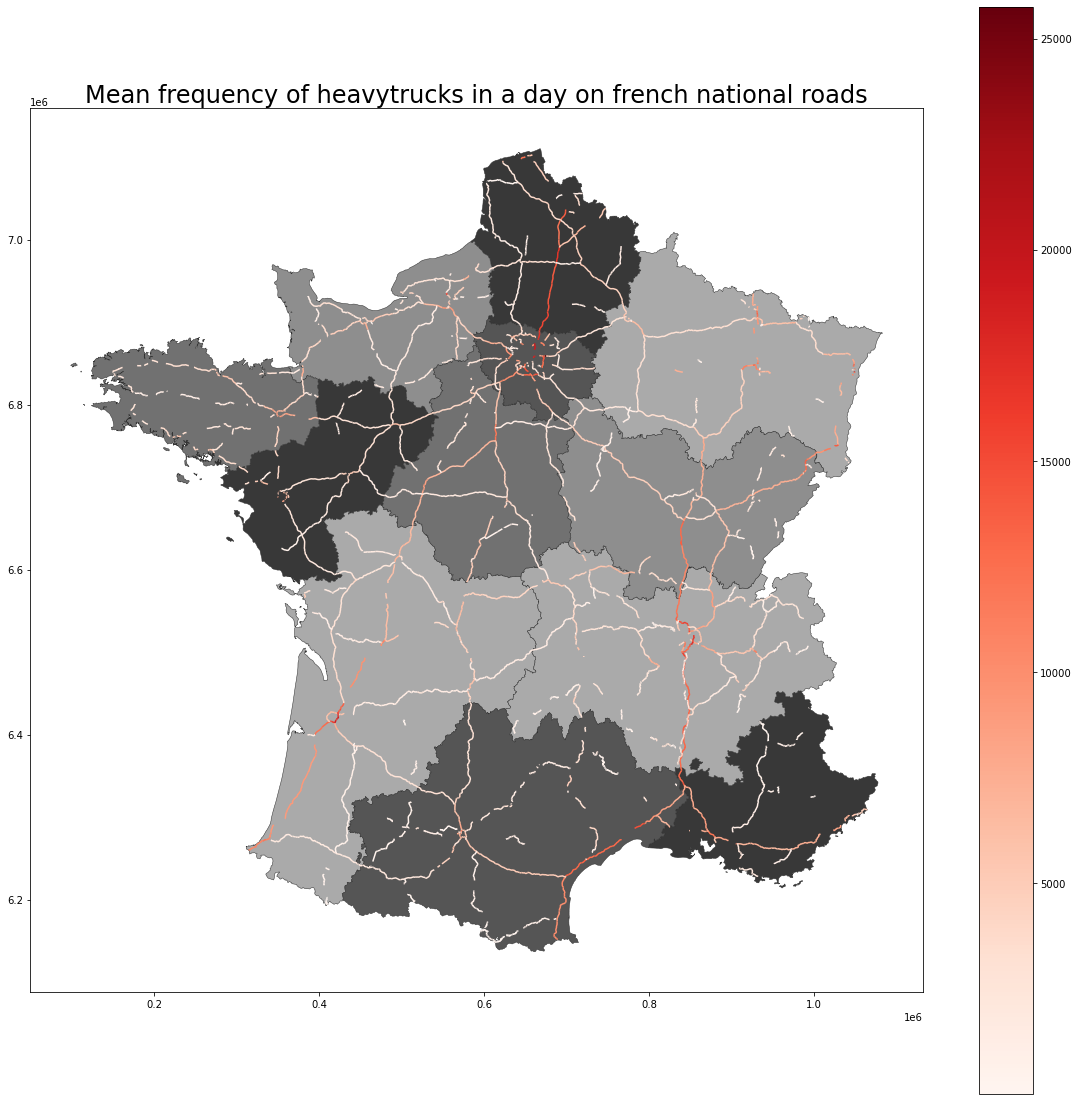

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, figsize=(20, 20))
ax.set_title('Mean frequency of heavytrucks in a day on french national roads',
             fontdict={'fontsize': '24', 'fontweight' : '3'})
rgba_array = mpl.cm.binary(np.linspace(0, 1, num=10, endpoint=True))
extract_rgba_array_255 = rgba_array[3:8,0:3]

fig = regions.plot(column='id_newregi', cmap=mpl.colors.ListedColormap(extract_rgba_array_255), linewidth=0.5, ax=ax, edgecolor='0.2',legend=False)
##final.plot(color='white', ax=ax)
fig2 = traffic.plot(column = 'nb_PL', cmap='Reds', ax=ax, legend=True)

In [ ]:
corresp_regions = {   
    'Grand Est': 0,
    'Nouvelle-Aquitaine': 1,
    'Auvergne-Rhône-Alpes': 2,
    'Normandie': 3,
    'Bourgogne-Franche-Comté': 4,
    'Bretagne': 5,
    'Centre-Val de Loire': 6,
    'Île-de-France': 8,
    'Occitanie': 9,
    'Hauts-de-France': 10,
    'Pays de la Loire': 11,
    "Provence-Alpes-Côte d'Azur": 12
}

geo_traffic_by_reg_prep = traffic_by_reg.copy()
geo_traffic_by_reg_prep['id_region'] = geo_traffic_by_reg_prep.region.apply(lambda x: corresp_regions[x])
geo_traffic_by_reg_prep = geo_traffic_by_reg_prep.merge(regions[['id_newregi', 'geometry']], left_on='id_region', right_on='id_newregi', how='left')
geo_traffic_by_reg_prep.drop(columns=['id_newregi'], inplace=True)
geo_traffic_by_reg_prep

geo_traffic_by_reg = gpd.GeoDataFrame(geo_traffic_by_reg_prep, geometry='geometry')
geo_traffic_by_reg

,region,nb_dep,nb_routes,total_longueur,nb_PL,id_region,geometry
0,Auvergne-Rhône-Alpes,12,834,2049960.0,2.969197e+06,2,"POLYGON ((769267.400 6575508.300, 769307.400 6..."
1,Bourgogne-Franche-Comté,8,300,1245297.0,1.260289e+06,4,"POLYGON ((996902.400 6711078.800, 996892.000 6..."
2,Bretagne,4,130,641649.0,5.288408e+05,5,"MULTIPOLYGON (((330478.600 6843657.900, 330488..."
3,Centre-Val de Loire,6,174,1090793.0,5.645867e+05,6,"POLYGON ((548948.900 6823333.300, 548949.000 6..."
4,Grand Est,9,212,1036696.0,1.216136e+06,0,"POLYGON ((909643.200 6936903.300, 909663.200 6..."
5,Hauts-de-France,5,183,1064753.0,6.873992e+05,10,"POLYGON ((598632.600 7042442.200, 598691.700 7..."
6,Normandie,5,204,1000354.0,6.602530e+05,3,"MULTIPOLYGON (((511688.800 6966776.900, 511693..."
7,Nouvelle-Aquitaine,12,379,2052367.0,1.468684e+06,1,"MULTIPOLYGON (((409608.500 6476609.100, 409643..."
8,Occitanie,13,407,1554019.0,1.114502e+06,9,"MULTIPOLYGON (((493119.100 6181124.600, 493099..."
9,Pays de la Loire,5,152,875857.0,4.879316e+05,11,"MULTIPOLYGON (((295044.400 6636866.000, 295114..."


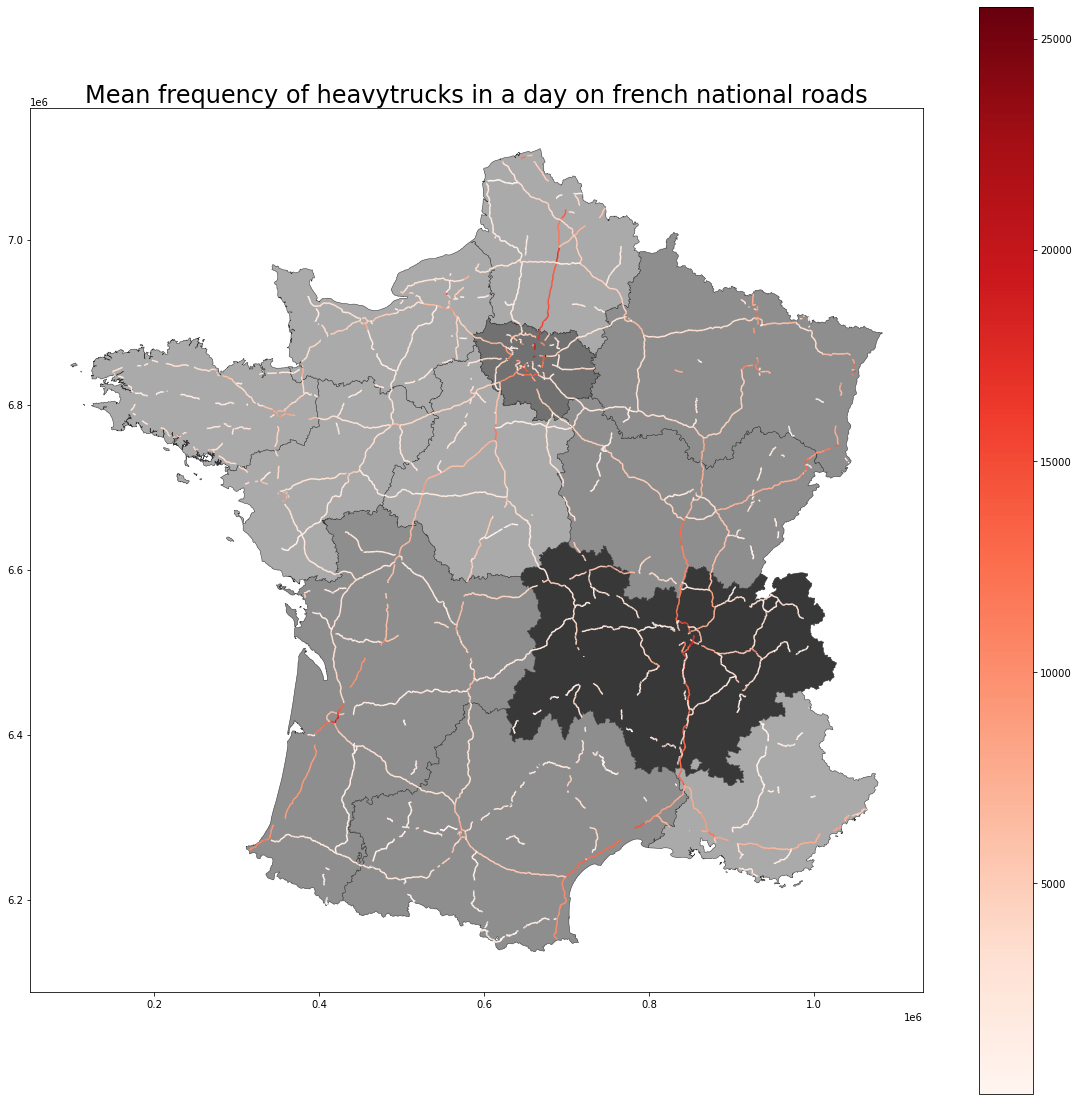

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, figsize=(20, 20))
ax.set_title('Mean frequency of heavytrucks in a day on french national roads',
             fontdict={'fontsize': '24', 'fontweight' : '3'})
rgba_array = mpl.cm.binary(np.linspace(0, 1, num=10, endpoint=True))
extract_rgba_array_255 = rgba_array[3:8,0:3]

fig = geo_traffic_by_reg.plot(column='nb_PL', cmap=mpl.colors.ListedColormap(extract_rgba_array_255), linewidth=0.5, ax=ax, edgecolor='0.2',legend=False)
fig2 = traffic.plot(column = 'nb_PL', cmap='Reds', ax=ax, legend=True)

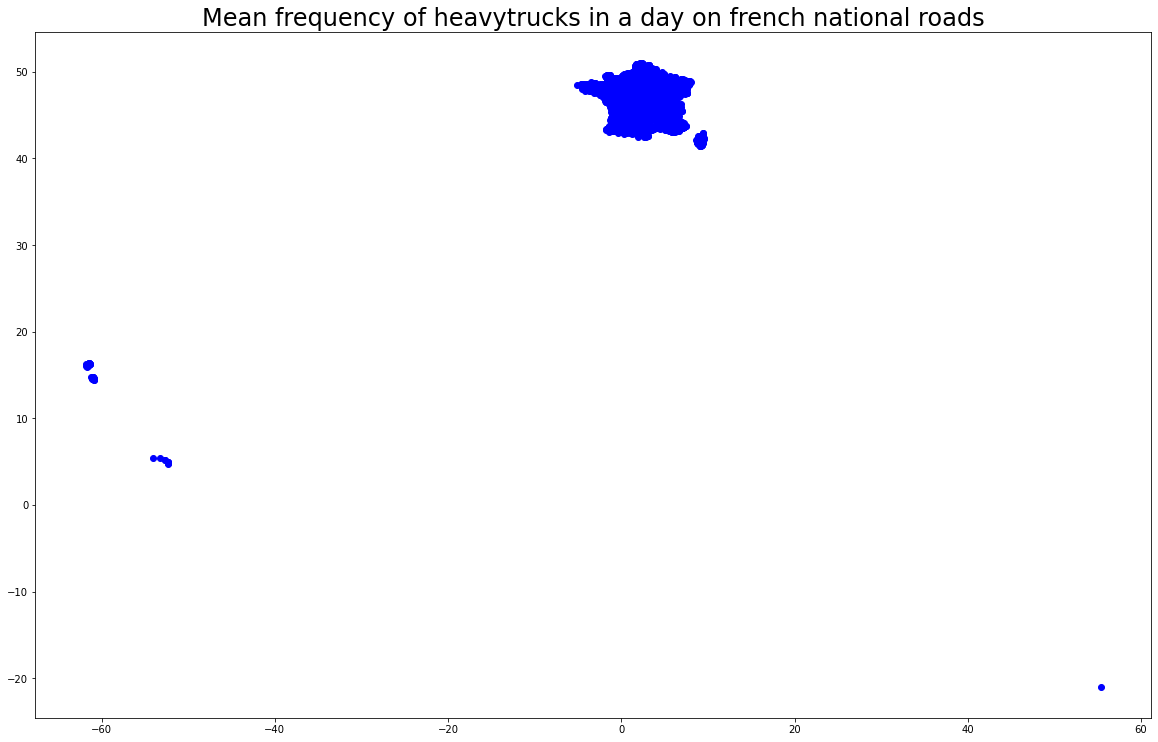

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(1, figsize=(20, 20))
ax.set_title('Mean frequency of heavytrucks in a day on french national roads',
             fontdict={'fontsize': '24', 'fontweight' : '3'})
rgba_array = mpl.cm.binary(np.linspace(0, 1, num=10, endpoint=True))
extract_rgba_array_255 = rgba_array[3:8,0:3]

# fig = geo_traffic_by_reg.plot(column='total_longueur', cmap=mpl.colors.ListedColormap(extract_rgba_array_255), linewidth=0.5, ax=ax, edgecolor='0.2',legend=False)
# fig2 = geo_traffic_by_reg.plot(column = 'nb_PL', cmap='Reds', ax=ax, legend=True)
fig3 = gdf_stations.plot(color='blue', ax=ax)

In [ ]:
3*10**6

3000000